from mne.time_frequency import psd_welch


In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve




import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
#from mne.time_frequency import psd_welch

from mne.decoding import cross_val_multiscore
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline


C:\Users\Asus\AppData\Local\Temp\ipykernel_29144\300748409.py:33: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


# Load dataset

The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.



In [2]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

a Python function read_eeg_signal_from_file that's intended to load EEG data from a file using the pickle module. This function appears to unpickle data from a binary file and return the loaded data. The data you're loading likely contains EEG signal information from a participant.

In [3]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


In [4]:
import numpy as np

labels = []
data = []

for i in files:
    filename = "pickled/s" + i + ".pickle"
    
    # Open the file in binary mode ('rb')
    with open(filename, 'rb') as file:
        # Read EEG signal data from the file using the appropriate function
        trial = read_eeg_signal_from_file(filename)
        labels.append(trial['labels'])
        data.append(trial['features'])



In [32]:
# Re-shape arrays into desired shapes as you did before
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(1280, 5, 17, 32) #This assumes that you have 880(data) rows and 4 columns(labels) of data.

data = np.array(data)
data = data.flatten()
data = data.reshape(40960, 85) #This shape implies that you have 880 samples, each with 40 rows and 8064 columns of data.


ValueError: cannot reshape array of size 2640 into shape (1280,5,17,32)

# Explore and pre-process data

## Labels

### Get Valence and Arousal ratings

Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.



In [19]:
# Convert 'labels' list to a NumPy array
labels = np.array(labels)

# Reshape the 'labels' array into a 2-D array with two columns (Valence and Arousal)
labels = labels.reshape(-1, 4)

# Extract Valence and Arousal ratings
valence = labels[:, 0]
arousal = labels[:, 1]
dominance = labels[:, 2]
liking = labels[:, 3]
# Create a DataFrame
df_label_ratings = pd.DataFrame({'Valence': valence, 'Arousal': arousal})

# Display statistics
print(df_label_ratings.describe())


          Valence     Arousal
count  660.000000  660.000000
mean     0.546970    0.562121
std      0.498167    0.496502
min      0.000000    0.000000
25%      0.000000    0.000000
50%      1.000000    1.000000
75%      1.000000    1.000000
max      1.000000    1.000000


## Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [20]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [21]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 361
Negative Valence: 299
High Arousal: 371
Low Arousal: 289


In [22]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 226
Low Arousal Positive Valence: 135
High Arousal Negative Valence: 145
Low Arousal Negative Valence: 154


### One hot encoding

In [23]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [24]:
# Initialize an empty list for labels_encoded
labels_encoded = []

# Iterate over your data points
for i in range(len(labels)):
    # Obtain the boolean values for "Positive Valence" and "High Arousal"
    positive_valence_value = positive_valence(i)
    high_arousal_value = high_arousal(i)

    # Append these values to the labels_encoded list as a list with two elements
    labels_encoded.append([positive_valence_value, high_arousal_value])

# Convert the list to a NumPy array
labels_encoded = np.array(labels_encoded)

# Create a DataFrame with the reshaped data
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])

# Print the summary statistics
print(df_labels.describe())


       Positive Valence  High Arousal
count        660.000000    660.000000
mean           0.546970      0.562121
std            0.498167      0.496502
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [25]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

In [26]:
# Extract the "Positive Valence" column into a new dataset
df_valence = df_labels['Positive Valence']

# Extract the "High Arousal" column into a new dataset
df_arousal = df_labels['High Arousal']

# Display the resulting datasets
print("Dataset with only Valence column:")
print(df_valence)

print("\nDataset with only Arousal column:")
print(df_arousal)


Dataset with only Valence column:
0      1
1      1
2      1
3      1
4      0
      ..
655    1
656    0
657    0
658    1
659    0
Name: Positive Valence, Length: 660, dtype: int32

Dataset with only Arousal column:
0      1
1      1
2      0
3      0
4      1
      ..
655    1
656    0
657    1
658    0
659    0
Name: High Arousal, Length: 660, dtype: int32


# EEG data

## Separate EEG and non-EEG data

In [27]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])


In [28]:
eeg_data = []


In [29]:
peripheral_data = []


# Train-test split and feature scaling

In [112]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
  return x_train, x_test, y_train, y_test

In [113]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

# Cross-validation to select classifier

Cross-validation is a technique used to assess the performance of a machine learning model while minimizing problems like overfitting or underfitting. It helps in selecting the best model by partitioning the dataset into training and testing subsets multiple times. Each partition is used for both training and testing to evaluate the model's performance

In [114]:
band_names = np.array(["delta", "theta", "alpha"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [115]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'linear', random_state = 20, probability=True)

In [116]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=4, weights='distance', algorithm='auto')

In [117]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))


In [118]:
import time
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

### Arousal - Accuracy

In [123]:
cross_validate_clf(eeg_data, df_arousal, 'accuracy')

ValueError: Found input variables with inconsistent numbers of samples: [0, 660]

### Arousal - F1

In [198]:
cross_validate_clf(eeg_band_arr, df_arousal, 'f1')

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


(['SVM', 'k-NN', 'MLP'],
 [0.6283524101895143, 0.5388054971905903, 0.6035878460313744],
 [0.06313773254804415, 0.06275980845022838, 0.07272418156535569],
 [0.9837913513183594, 0.027692794799804688, 10.20068907737732])

### Valence - Accuracy


In [199]:
cross_validate_clf(eeg_band_arr, df_valence, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5597061803444783, 0.5881661600810537, 0.5782168186423505],
 [0.02458061975615945, 0.03742596910454223, 0.037068223148220066],
 [1.289656639099121, 0.02600240707397461, 9.236920356750488])

### Valence - F1

In [200]:
cross_validate_clf(eeg_band_arr, df_valence, 'f1')

(['SVM', 'k-NN', 'MLP'],
 [0.5822429739421733, 0.6042545507633911, 0.5886140735265648],
 [0.03548302115448638, 0.04723083489893027, 0.07137441667247266],
 [0.9256598949432373, 0.025663137435913086, 7.70525860786438])

# Classification

### Functions to run classifiers

In [201]:
def run_clf_cv(band, channel, label, clf):
  if (band == "delta"):
    df_x = df_delta
  elif (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  

  if (channel == "left"):
    df_x = df_x[left]
  elif (channel == "right"):
    df_x = df_x[right]
  elif (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply CV
  x_for_kfold = np.array(x_train)            
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)

  return y_test2, y_predict

In [202]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [203]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (3,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [204]:
def get_f1(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(f1_score(y_test2, y_predict)*100,2)

In [205]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (3,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [206]:
def plot_cm(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  cm = confusion_matrix(y_test2, y_predict)
  print(cm)
  cr = classification_report(y_test2, y_predict)
  print(cr)

  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  if (label == "valence"):
    classes = df_valence.unique().tolist()
  if (label == "arousal"):
    classes = df_arousal.unique().tolist()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


## Accuracy results

### Valence

In [207]:
# Only use k-NN in case of Valence after CV
print_accuracy('valence', 'knn')

Top 3 EEG regions with highest scores
central    64.29
right      63.57
frontal    60.71
dtype: float64

Top 2 bands with highest scores
alpha    64.29
theta    63.57
dtype: float64

EEG region with highest scores per each band
delta    central
theta      right
alpha    central
dtype: object

Band with highest scores per each EEG region
left         alpha
frontal      theta
right        theta
central      alpha
parietal     theta
occipital    alpha
dtype: object

        left  frontal  right  central  parietal  occipital
delta  56.43    56.43  55.00    60.00     55.71      55.71
theta  56.43    60.71  63.57    62.14     60.71      59.29
alpha  59.29    57.14  57.14    64.29     59.29      60.00


### Arousal

In [208]:
# Only use MLP in case of Arousal after CV
print_accuracy('arousal', 'mlp')

Top 3 EEG regions with highest scores
parietal    60.00
frontal     58.57
central     54.29
dtype: float64

Top 2 bands with highest scores
alpha    60.00
theta    59.29
dtype: float64

EEG region with highest scores per each band
delta    parietal
theta    parietal
alpha    parietal
dtype: object

Band with highest scores per each EEG region
left         theta
frontal      theta
right        delta
central      theta
parietal     alpha
occipital    theta
dtype: object

        left  frontal  right  central  parietal  occipital
delta  49.29    55.00  52.86    53.57     58.57      49.29
theta  50.71    58.57  51.43    54.29     59.29      52.14
alpha  49.29    58.57  52.14    54.29     60.00      52.14


## F1 score results

### Valence

In [209]:
# Only use k-NN in case of Valence after CV
print_f1('valence', 'knn')

Top 3 EEG regions with highest scores
right       70.52
central     69.14
parietal    67.46
dtype: float64

Top 2 bands with highest scores
theta    70.52
alpha    69.14
dtype: float64

EEG region with highest scores per each band
delta    central
theta      right
alpha    central
dtype: object

Band with highest scores per each EEG regions
left         alpha
frontal      theta
right        theta
central      alpha
parietal     theta
occipital    theta
dtype: object

        left  frontal  right  central  parietal  occipital
delta  58.50    61.15  60.38    64.10     59.21      62.65
theta  63.03    66.67  70.52    68.26     67.46      65.87
alpha  65.87    62.50  62.03    69.14     62.75      65.85


### Arousal

In [210]:
# Only use MLP in case of Arousal after CV
print_f1('arousal', 'mlp')

Top 3 EEG regions with highest scores
parietal     67.06
frontal      66.67
occipital    64.55
dtype: float64

Top 2 bands with highest scores
alpha    67.06
theta    66.67
dtype: float64

EEG region with highest scores per each band
delta    parietal
theta     frontal
alpha    parietal
dtype: object

Band with highest scores per each EEG regions
left         theta
frontal      theta
right        alpha
central      theta
parietal     alpha
occipital    alpha
dtype: object

        left  frontal  right  central  parietal  occipital
delta  60.67    63.91  63.39    63.28     65.88      63.39
theta  61.02    66.67  62.70    64.04     66.27      63.83
alpha  60.34    64.29  63.44    64.04     67.06      64.55


## Plot results

### Top combinations for Valence

[[30 28]
 [25 57]]
              precision    recall  f1-score   support

           0       0.55      0.52      0.53        58
           1       0.67      0.70      0.68        82

    accuracy                           0.62       140
   macro avg       0.61      0.61      0.61       140
weighted avg       0.62      0.62      0.62       140



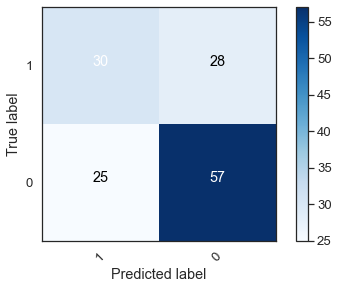

In [211]:
plot_cm('theta', 'central', 'valence', 'knn')

[[28 30]
 [27 55]]
              precision    recall  f1-score   support

           0       0.51      0.48      0.50        58
           1       0.65      0.67      0.66        82

    accuracy                           0.59       140
   macro avg       0.58      0.58      0.58       140
weighted avg       0.59      0.59      0.59       140



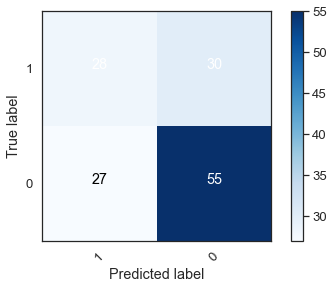

In [212]:
plot_cm('alpha', 'left', 'valence', 'knn')

[[29 29]
 [34 48]]
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        58
           1       0.62      0.59      0.60        82

    accuracy                           0.55       140
   macro avg       0.54      0.54      0.54       140
weighted avg       0.56      0.55      0.55       140



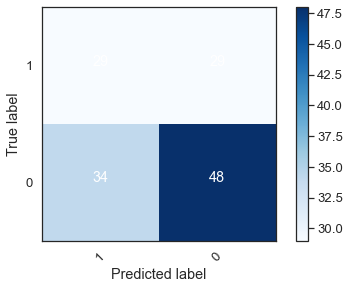

In [213]:
plot_cm('delta', 'right', 'valence', 'knn')

### Top combinations for Arousal

[[18 52]
 [12 58]]
              precision    recall  f1-score   support

           0       0.60      0.26      0.36        70
           1       0.53      0.83      0.64        70

    accuracy                           0.54       140
   macro avg       0.56      0.54      0.50       140
weighted avg       0.56      0.54      0.50       140



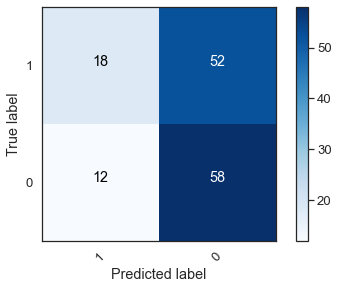

In [214]:
plot_cm('alpha', 'central', 'arousal', 'mlp')

[[26 44]
 [13 57]]
              precision    recall  f1-score   support

           0       0.67      0.37      0.48        70
           1       0.56      0.81      0.67        70

    accuracy                           0.59       140
   macro avg       0.62      0.59      0.57       140
weighted avg       0.62      0.59      0.57       140



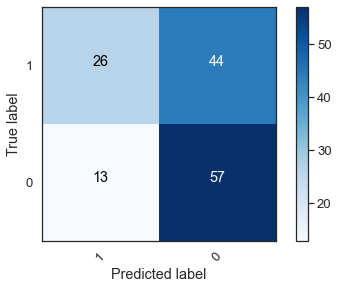

In [215]:
plot_cm('theta', 'parietal', 'arousal', 'mlp')